# Welcome to the ssl-legacysurvey tutorial

This tutorial will walk you through all functionalities of this project, including:
    
- Loading the legacysurvey data
- Self-supervised training
- Extracting representations
- Additional Dimensionality reduction

## First import the necessary modules and define some defaults

In [150]:
%load_ext autoreload
%autoreload 2

import os
# os.environ['OPENBLAS_NUM_THREADS'] = '1'

import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

from ssl_legacysurvey.utils import load_data # Loading galaxy catalogue and image data from hdf5 file(s)
from ssl_legacysurvey.utils import plotting_tools as plt_tools # Plotting images or catalogue info

from ssl_legacysurvey.data_loaders import datamodules # Pytorch dataloaders and datamodules
from ssl_legacysurvey.data_loaders import decals_augmentations # Augmentations for training

from ssl_legacysurvey.data_analysis import dimensionality_reduction # PCA/UMAP functionality

data_path = "../data/tiny_dataset.h5"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
# Define matplotlib defaults
plt.rcParams['figure.figsize']        = 8., 6.
plt.rcParams['axes.labelsize']        = 18
plt.rcParams['axes.titlesize']        = 18
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 18
plt.rcParams['ytick.labelsize']       = 18
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = False
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.size']             = 18


## Load the data to have a quick look

A very small subset of 64 galaxies is included in as part of the github repository `data/tiny_dataset.h5`

For the publically-available full catalogue of 75 million galaxies see the README, which includes instructions on how to copy the data to your local cluster using [Globus file transfer](https://www.globus.org/). 

In [116]:
# Load h5py file into dictionary

DDL = load_data.DecalsDataLoader(image_dir=data_path)

gals = DDL.get_data(-1, fields=DDL.fields_available) # -1 to load all galaxies

print("Available keys & data shapes:")
for k in gals:
    print(f"{k} shape:", gals[k].shape)

Available keys & data shapes:
inds shape: (64,)
brickid shape: (64,)
dec shape: (64,)
ebv shape: (64,)
fiberflux_g shape: (64,)
fiberflux_r shape: (64,)
fiberflux_z shape: (64,)
fracin_g shape: (64,)
fracin_r shape: (64,)
fracin_z shape: (64,)
images shape: (64, 3, 152, 152)
mag_g shape: (64,)
mag_r shape: (64,)
mag_z shape: (64,)
maskbits shape: (64,)
nobs_g shape: (64,)
nobs_r shape: (64,)
nobs_z shape: (64,)
objid shape: (64,)
psfdepth_g shape: (64,)
psfdepth_r shape: (64,)
psfdepth_z shape: (64,)
psfsize_g shape: (64,)
psfsize_r shape: (64,)
psfsize_z shape: (64,)
ra shape: (64,)
release shape: (64,)
source_type shape: (64,)
transmission_g shape: (64,)
transmission_r shape: (64,)
transmission_z shape: (64,)
z_phot_l68 shape: (64,)
z_phot_l95 shape: (64,)
z_phot_mean shape: (64,)
z_phot_median shape: (64,)
z_phot_std shape: (64,)
z_phot_u68 shape: (64,)
z_phot_u95 shape: (64,)
z_spec shape: (64,)
z_training shape: (64,)


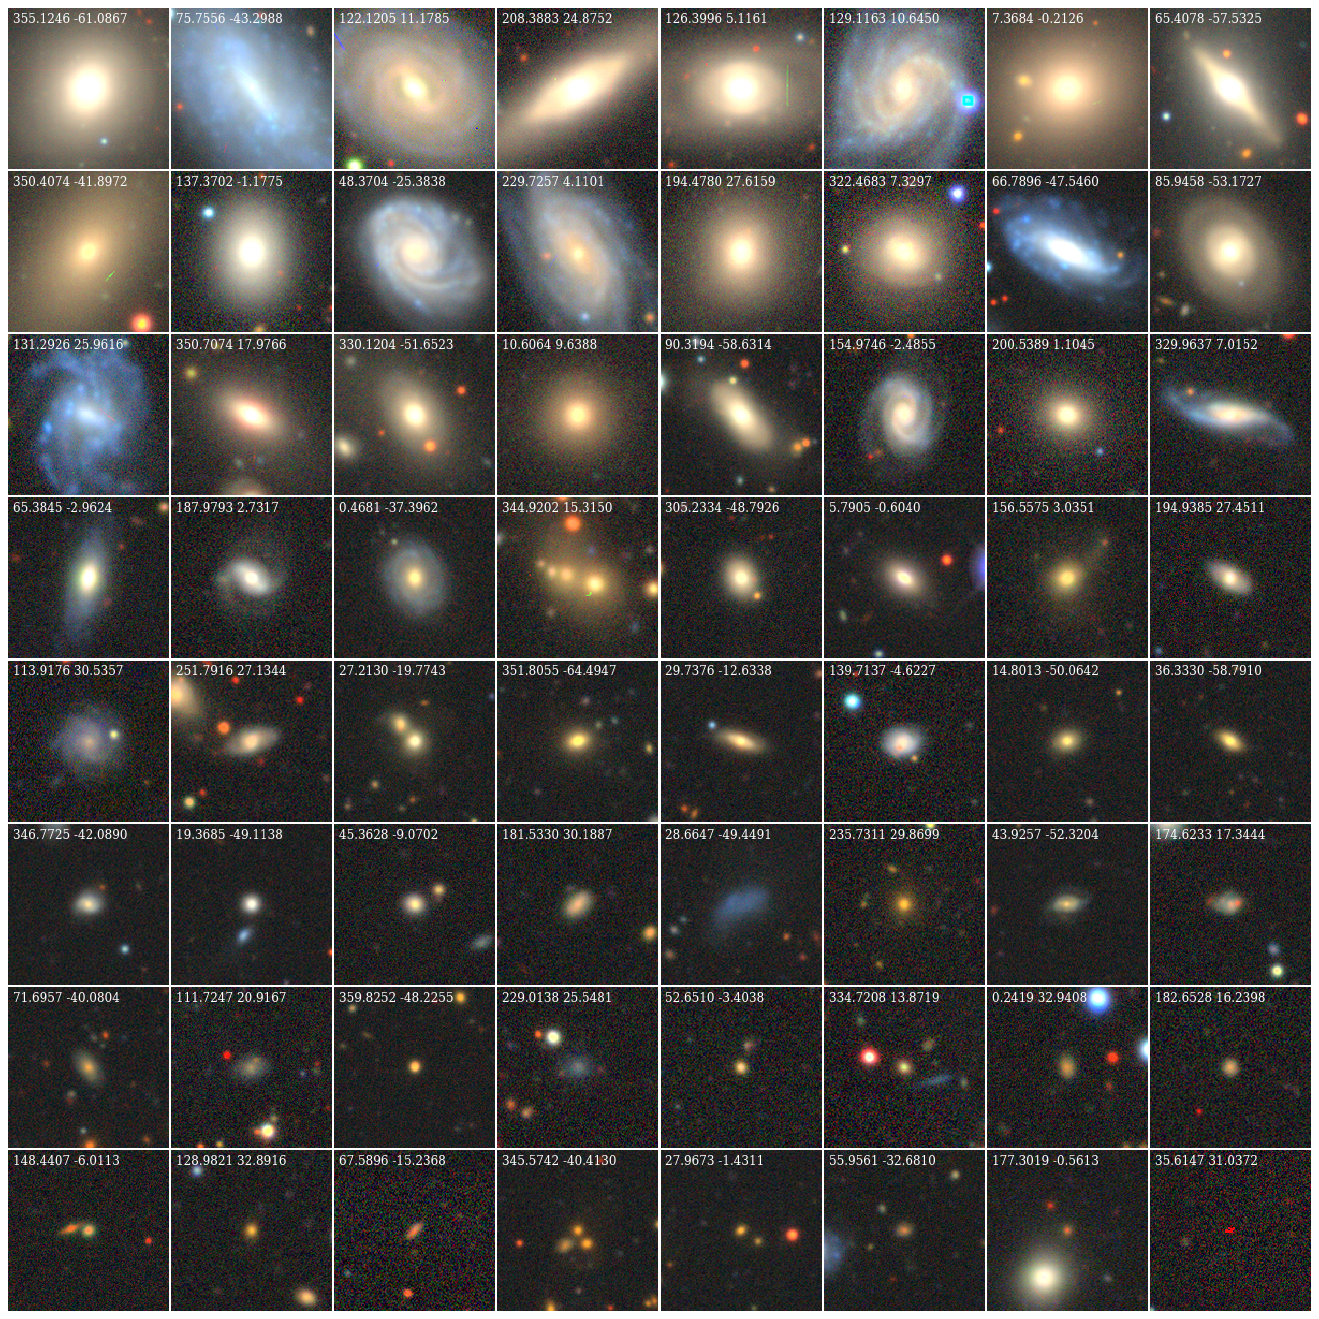

In [117]:
# Display some pretty galaxy pictures
nplt = 64
ncol = 8
npix_show = 152

# Display images in grid, with ra/dec for each galaxy. Colors are after grb transformation, not raw data
plt_tools.show_galaxies(gals['images'], gals['ra'], gals['dec'], 
                        nx=ncol, nplt=nplt, npix_show=npix_show)


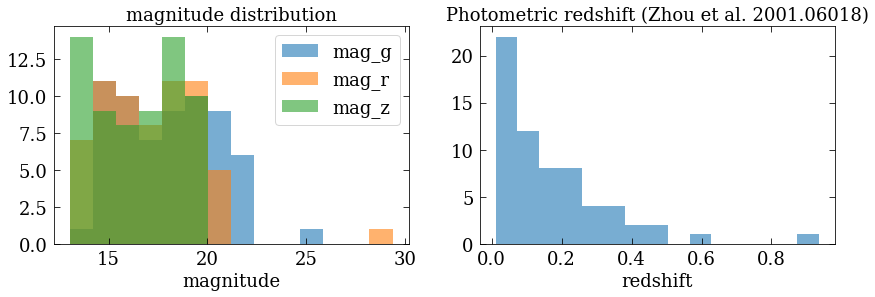

In [118]:
# Display some galaxy info
nbins = 15
bins = np.linspace(
    np.min([gals['mag_g'], gals['mag_r'], gals['mag_z']]),
    np.max([gals['mag_g'], gals['mag_r'], gals['mag_z']]),
    nbins,
)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
for band in ['g', 'r', 'z']:
    ax[0].hist(gals[f'mag_{band}'], bins=bins, label=f'mag_{band}', alpha=0.6) #histtype='step')

ax[1].hist(gals['z_phot_mean'], bins=nbins, alpha=0.6) #histtype='step')

ax[0].legend()
ax[0].set_xlabel('magnitude')
ax[0].set_title('magnitude distribution')

ax[1].set_xlabel('redshift')
ax[1].set_title('Photometric redshift (Zhou et al. 2001.06018)');


# Perform self-supervised learning

This tutorial just shows the basics, and without distributed training it will be much too slow on the full dataset!

**For full functionality (distributed training, proper experiment logging, etc.) see `scripts/train_ssl.py`.** 

**This is just a quick example to get an idea of PyTorch-Lightning and the self-supervised learning process**

### Imports

In [119]:
# Import necessary modules for self-supervised learning 
# To prevent OpenBLAS blas_thread_init
# os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import torch
import torchvision
import pytorch_lightning as pl
import h5py

import argparse
import logging

from pathlib import Path
import os
import sys
import glob

from pytorch_lightning import loggers as pl_loggers
# from pl_bolts.models.self_supervised import Moco_v2
from pytorch_lightning.plugins import DDPPlugin

from ssl_legacysurvey.moco.moco2_module import Moco_v2
from ssl_legacysurvey.data_loaders import datamodules
from ssl_legacysurvey.utils import format_logger

### Set up training parameters

In [136]:
class Args: # In general codes in this project use argparse. Args() simplifies this for this example 
    # Data location and GPU availability 
    data_path = "../data/tiny_dataset.h5"
    gpu = True # Use GPU?
    gpus = 1 # Number of gpus to use
    num_nodes = 1

    # Training
    verbose = True
    ssl_training = True
    batch_size = 8
    learning_rate = 0.03
    max_epochs = 100
    
    check_val_every_n_epoch = 999 # We haven't provided validation set, so don't use it!
    num_sanity_val_steps = 0

    augmentations = 'grrrssgbjcgnrg'
    jitter_lim = 7
    
    strategy = 'dp' # Distributed training strategy,  ddp does not work in ipython notebook, only dp does
    seed = 13579

    checkpoint_every_n_epochs = 1
    num_workers = 1 # Number of workers for data loader

    # Model architecture and settings
    backbone = 'resnet18' # Encoder architecture to use, Can use any in torchvision, i.e. ['resnet18', 'resnet34', 'resnet50', 'resnet152', .....]
    use_mlp = True # use projection head

    emb_dim = 128 # Dimensionality where loss is calculated
    num_negatives = 16 #Number of negative samples to keep in queue for Mocov2

    OUTPUT_DIR = 'test/'

params = vars(Args)
p = {}
for k, v in params.items():
    p[k] = v
params = p

### Train MoCov2 model

In [137]:
# Set up self-supervised model
model = Moco_v2(
    base_encoder=params['backbone'],
    emb_dim=params['emb_dim'],
    use_mlp=params['use_mlp'],
    learning_rate=params['learning_rate'],
    batch_size=params['batch_size'],
)

# Set up datamodule
datamodule = datamodules.DecalsDataModule(params)

# Set up callbacks
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=params['OUTPUT_DIR'],
    filename='{epoch:03d}',
    every_n_epochs=params['checkpoint_every_n_epochs'],
    save_top_k=-1,
    save_on_train_epoch_end=True,
    verbose=True,
    save_last=True,
)

lr_monitor = pl.callbacks.LearningRateMonitor(
    logging_interval='epoch',
)

# Define Pytorch-Lightning trainer
trainer = pl.Trainer.from_argparse_args(
    Args,
    strategy=params['strategy'],
    callbacks=[checkpoint_callback, lr_monitor],
)

# Fit model
trainer.fit(
    model,
    datamodule=datamodule,
)


ModelCheckpoint(save_last=True, save_top_k=-1, monitor=None) will duplicate the last checkpoint saved.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/global/homes/g/gstein/.conda/envs/ssl-pl/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:88: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/global/homes/g/gstein/.conda/envs/ssl-pl/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:107: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/global/homes/g/gstein/.conda/envs/ssl-pl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /pscratch/sd/g/gstein/machine_learning/decals_self_supervised/ssl-legacysurvey-pl/no

Training: 0it [00:00, ?it/s]

/global/homes/g/gstein/.conda/envs/ssl-pl/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:2011: LightningDeprecationWarning: `Trainer.training_type_plugin` is deprecated in v1.6 and will be removed in v1.8. Use `Trainer.strategy` instead.
  rank_zero_deprecation(


### Use the trained model

When using MoCov2 we have two backbone encoders, encoder_q and encoder_k

encoder_k is only necessary for self-supervised training, while encoder_q is the trained model we want

**Use `scripts/predict.py` to run network over real dataset (extracting representations or predictions).
Below is just a short example to get an idea of the process!**

In [139]:
# Set self-supervised encoder as out backbone
backbone = model.encoder_q

# Remove the MLP projection head from the model, so output is now the representaion for each galaxy
backbone.fc = torch.nn.Identity()

params['ssl_training'] = False
params['jitter_lim'] = 0
params['augmentations'] = 'jcrg'

# Load in images (in the same format as the network was trained on. Note this is not the same as the original data in the .h5 file!)
# Load all images as one batch
transform = datamodules.DecalsTransforms(params)

decals_dataloader = datamodules.DecalsDataset(
    params['data_path'],
    None,
    transform,
    params,
)

ngals = decals_dataloader.__len__()

im, label = decals_dataloader.__getitem__(0)
images = torch.empty((ngals, im.shape[0], im.shape[1], im.shape[2]), dtype=im.dtype)
for i in range(ngals):
    images[i], _ = decals_dataloader.__getitem__(i)

# Run images through model to get representations
representations = backbone(images)

In [140]:
# Move pytorch tensors to CPU (if on GPU) and to numpy

if params['gpu']:
    images, representations = images.detach(), representations.detach()
images, representations = images.numpy(), representations.numpy()


### Visualize representations

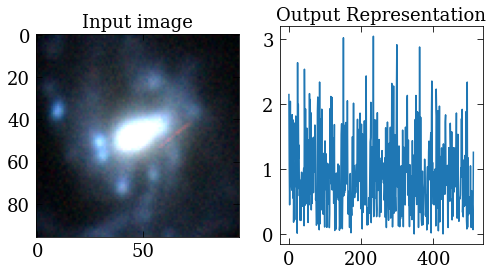

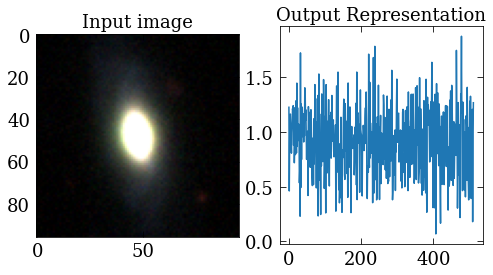

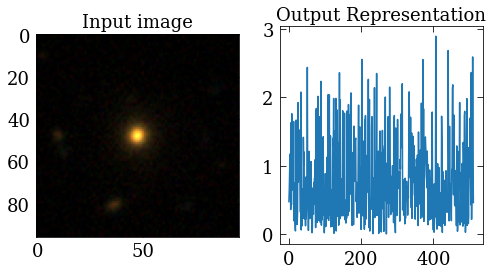

In [141]:
np.random.seed(13579)
nplt = 3
inds_plt = np.arange(images.shape[0])
inds_plt = sorted(np.random.choice(ind_plt, min(nplt, inds_plt.shape[0]), replace=False))

for i in inds_plt:
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    
    imi, repi = images[i], representations[i]
    
    ax[0].imshow(np.swapaxes(imi, 0, 2))
    ax[1].plot(repi)
    ax[0].set_title("Input image")
    ax[1].set_title("Output Representation")

### We see that by eye it is hard to decipher what the 512-dimensional representation vector has learned (probably very little in this tiny training example....)

So lets reduce the dimensionality further and visualize it



In [147]:
from ssl_legacysurvey.data_analysis import dimensionality_reduction
from ssl_legacysurvey.utils import plotting_tools as plt_tools # Plotting images or catalogue info

pca_components, rep_pca, pca = dimensionality_reduction.pca_transform(representations, n_components=2)
umap_embedding, umap_trans = dimensionality_reduction.umap_transform(representations, n_components=2, metric='cosine')


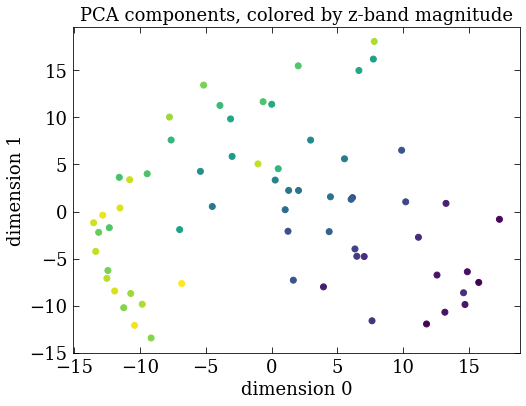

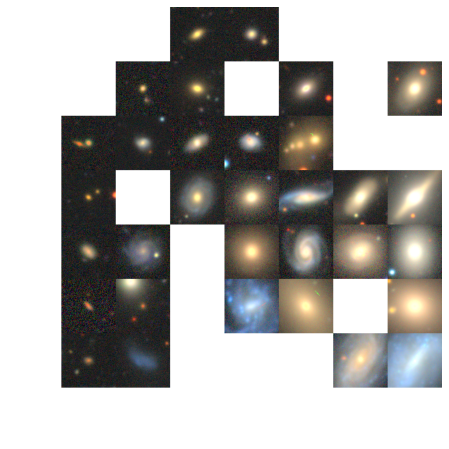

In [148]:
# Look at PCA decomposition

plt.figure()
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=gals['mag_z'])
plt.xlabel('dimension 0')
plt.ylabel('dimension 1')
plt.title('PCA components, coloured by z-band magnitude')

# Plot as images in a fancy plot
nx, ny = 8, 8
inds_use = np.arange(images.shape[0])
im = plt_tools.scatter_plot_as_images(DDL, pca_components, inds_use, nx=nx, ny=ny)


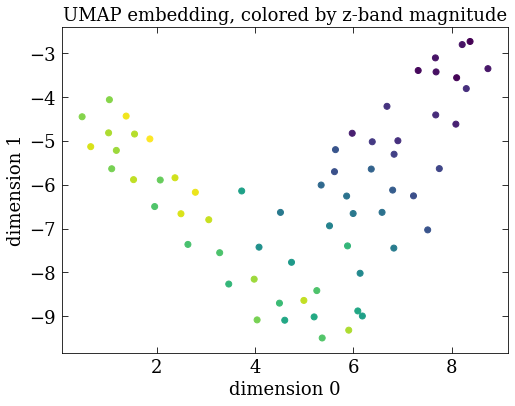

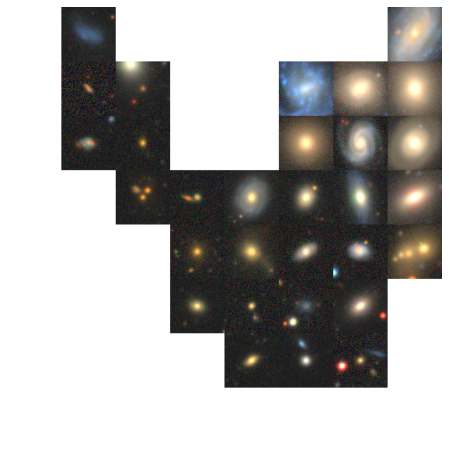

In [149]:
# Look at UMAP embedding

plt.figure()
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=gals['mag_z'])
plt.xlabel('dimension 0')
plt.ylabel('dimension 1')
plt.title('UMAP embedding, coloured by z-band magnitude')

# Plot as images in a fancy plot
nx, ny = 8, 8
inds_use = np.arange(images.shape[0])
im = plt_tools.scatter_plot_as_images(DDL, umap_embedding, inds_use, nx=nx, ny=ny)

# This project contains much more functionality beyond this simple tutorial!!

`scripts/finetune.py`: Train classification or regression models (from scratch or pre-trained on ImageNet), or finetune a self-supervised model


`dimensionality_reduction.py`: Fit on subset of image or representation data, them run PCA or UMAP over full dataset

`similarity_search_nxn.py`: Performs an N x N similarity search, where N is the number of representations. Used to  construct my interactive [Galaxy Search](https://share.streamlit.io/georgestein/galaxy_search) app. Requires Facebook's [Faiss](https://github.com/facebookresearch/faiss).